In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import gc

import lightgbm as lgb
from datetime import date, timedelta

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

#import pytorch
#import pytorch.nn as nn

In [3]:
#functions: dowcast()  construct data frame prepare_data

#model: lightgbm, lstm, transformers

In [4]:
def downcast(df):
    numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    mem_use = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype in numeric_types:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_dtype)[:3] == 'int':
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                elif col_max < np.iinfo(np.int64):
                    df[col] = df[col].astype(np.int64)
            else:
                if col_max < np.finfo(np.float16).max and col_min > np.finfo(np.float16).min:
                    df[col] = df[col].astype(np.float16)
                elif col_max < np.finfo(np.float32).max and col_min > np.finfo(np.float32).min:
                    df[col] = df[col].astype(np.float32)
                elif col_max < np.finfo(np.float64).max and col_min > np.finfo(np.float64).min:
                    df[col] = df[col].astype(np.float64)
    mem_use_now = df.memory_usage().sum() / 1024 ** 2
    red_pct = (mem_use - mem_use_now) / mem_use
    
    print('Memory usage before downcast is: ', mem_use)
    print('Memory usage after downcast is: ', mem_use_now)
    print('Memory reduced by:{:.2f}'.format(red_pct))
    
    return df

In [5]:
def build_df(sales_train):
    frame = []
    for block_num in sales_train['date_block_num'].unique():
        shop_id = sales_train['shop_id'].unique()
        item_id = sales_train['item_id'].unique()
        block = np.array(list(product(*[shop_id, item_id, [block_num]])), dtype=np.int16)
        frame.append(block)

    df = pd.DataFrame(np.vstack(frame), columns=['shop_id', 'item_id', 'date_block_num'])
    del frame
    gc.collect()
    index_col = ['shop_id', 'item_id', 'date_block_num']

    monthly_sales = sales_train.groupby(by=index_col).agg({
        'item_cnt_day' : 'sum',
        'item_price' : 'mean',
    }).reset_index()

    df_ = df.merge(right = monthly_sales, on=index_col, how = 'left')
    df_ = downcast(df_)
    del df
    gc.collect()
    
    df_['item_cnt_day'] = df_['item_cnt_day'].fillna(0)
    df_['item_price'] = df_['item_price'].fillna(0)
    df_['item_cnt_day'] = df_['item_cnt_day'].astype(int)
    ym = pd.Series(pd.date_range('1/1/2013', periods=sales_train.date_block_num.nunique(), freq = 'M'))
    dict_ = dict(zip(np.sort(monthly_sales.date_block_num.unique()), ym))
    df_['date'] = df_['date_block_num'].map(dict_)
    return df_

In [6]:
def get_date_range(df, dt, forward_steps, periods, freq):
    return df[pd.date_range(start = dt-pd.offsets.DateOffset(months=forward_steps), periods=periods, freq=freq)]

## Strategy

+ Only use sales in 2015 as the target df_st = df_.set_index(['shop_id', 'item_id', 'date'])['item_cnt_day'].unstack(level=-1)to train

In [7]:
def prepare_dataset(start_date, is_train=True):
    tmpDict = {}
    for i in range(1, 11):  #historical sales in past 10 months
        name = "month_{}_hist".format(i)
        chunck = get_date_range(df_st, start_date, i, 1, 'M').values.ravel()
        tmpDict[name] = chunck
    X = pd.DataFrame(tmpDict)
    
    for i in [1,2,3,4,5,6]:
        X['diff_{}_months_mean'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').diff(axis=1).mean(axis=1).values
        X['mean_{}_months'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').mean(axis=1).values
        X['median_{}_months'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').median(axis=1).values
        X['max_{}_months'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').max(axis=1).values
        X['std_{}_months'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').std(axis=1).values
        X['min_{}_months'.format(i)] = get_date_range(df_st, start_date, i, i, 'M').min(axis=1).values
    
    #diff with sales in the past months
    for i in [1,2,3,4,5,6]:
        X['diff_{}_months'.format(i)] = get_date_range(df_st, start_date, i, 1, 'M').values - get_date_range(df_st, start_date, i+1, 1, 'M').values
    
    
    if is_train==True:
        y = df_st[pd.date_range(start_date, periods=1)].values
        return X, y
    
    return X

## Load data and do some preparation

In [8]:
sales_train = pd.read_csv("sales_train.csv")
sales_train['date'] = pd.to_datetime(sales_train['date'], format="%d.%m.%Y")
sales_train = downcast(sales_train)

Memory usage before downcast is:  134.3926239013672
Memory usage after downcast is:  50.39731025695801
Memory reduced by:0.62


In [9]:
df_ = build_df(sales_train)

Memory usage before downcast is:  848.5084533691406
Memory usage after downcast is:  763.6576080322266
Memory reduced by:0.10


In [10]:
df_.head(1)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,date
0,59,22154,0,1,999.0,2013-01-31


In [11]:
## Drop outliers

df_.describe()

,shop_id,item_id,date_block_num,item_cnt_day,item_price
count,4.448628e+07,4.448628e+07,4.448628e+07,4.448628e+07,4.448628e+07
mean,2.950000e+01,1.109870e+04,1.650000e+01,8.200742e-02,2.858600e+01
std,1.731810e+01,6.396913e+03,9.810709e+00,1.698661e+00,3.285133e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
25%,1.475000e+01,5.551000e+03,8.000000e+00,0.000000e+00,0.000000e+00
50%,2.950000e+01,1.110500e+04,1.650000e+01,0.000000e+00,0.000000e+00
75%,4.425000e+01,1.664800e+04,2.500000e+01,0.000000e+00,0.000000e+00
max,5.900000e+01,2.216900e+04,3.300000e+01,2.252000e+03,3.079800e+05


In [12]:
df_['item_cnt_day'].sort_values(ascending=False)

43730078    2252
42434679    1644
42936174    1644
14991817    1305
36394086    1242
            ... 
13642298      -4
25418332      -5
545499        -6
552116       -13
13632793     -22
Name: item_cnt_day, Length: 44486280, dtype: int32

In [13]:
df_['item_cnt_day'][df_['item_cnt_day']>=1000] = 0
df_['item_cnt_day'][df_['item_cnt_day']<0] = 0

C:\Users\shiju\AppData\Local\Temp/ipykernel_8592/1835740606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['item_cnt_day'][df_['item_cnt_day']>=1000] = 0
C:\Users\shiju\AppData\Local\Temp/ipykernel_8592/1835740606.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['item_cnt_day'][df_['item_cnt_day']<0] = 0


In [14]:
df_st = df_.set_index(['shop_id', 'item_id', 'date'])['item_cnt_day'].unstack(level=-1)

In [15]:
gc.collect()

0

## run the model

In [16]:
X_l=[]
y_l=[]
n_range = 6
start_date = date(2015, 8, 31)
for i in tqdm(range(n_range)):
    #3 month a period
    offset = pd.offsets.DateOffset(months=i)
    X, y = prepare_dataset(start_date - offset, is_train=True)
    X_l.append(X)
    y_l.append(y)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

del X_l, y_l
##data for last two months in train as the validation data
X_v=[]
y_v=[]
start_date_v = date(2015, 10, 31)
n_range=2
for i in tqdm(range(n_range)):
    offset = pd.offsets.DateOffset(months=i)
    X, y = prepare_dataset(start_date-offset, is_train=True)
    X_v.append(X)
    y_v.append(y)

X_val = pd.concat(X_v, axis=0)
y_val = np.concatenate(y_v, axis=0)
del X_v, y_v

gc.collect()
## test set
test_X = prepare_dataset(date(2015, 11, 30), is_train=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.66s/it]


In [17]:
X_train, X_val = downcast(X_train), downcast(X_val)

Memory usage before downcast is:  2335.8938598632812
Memory usage after downcast is:  928.3680725097656
Memory reduced by:0.60
Memory usage before downcast is:  778.6312866210938
Memory usage after downcast is:  306.96041107177734
Memory reduced by:0.61


In [26]:
train = X_train.copy()
train['y'] = y_train


val = X_val.copy()
val['y'] = y_val

In [30]:
train[train.select_dtypes(include='float16').columns] = train.select_dtypes(include='float16').astype('float32')

In [31]:
val[val.select_dtypes(include='float16').columns] = val.select_dtypes(include='float16').astype('float32')

In [32]:
test_X[test_X.select_dtypes(include='float16').columns] = test_X.select_dtypes(include='float16').astype('float32')

In [33]:
train.to_parquet("train.parquet.gzip", compression='gzip')
val.to_parquet("val.parquet.gzip", compression='gzip')
test_X.to_parquet("test.parquet.gzip", compression='gzip')

In [18]:
import lightgbm as lgb

In [21]:
train_data = lgb.Dataset(X_train, y_train)
val_data = train_data.create_valid(X_val, y_val)
test_data = train_data.create_valid(test_X)

In [23]:
train_data.save_binary("train_dataset.bin")
val_data.save_binary("val_dataset.bin")
test_data.save_binary("test_dataset.bin")

[LightGBM] [Info] Saving data to binary file train_dataset.bin
[LightGBM] [Info] Saving data to binary file val_dataset.bin
[LightGBM] [Info] Saving data to binary file test_dataset.bin


In [20]:
initial_params = {
    'objective': 'regression_l2',
    'n_estimators' : 500,
    'boosting_type': 'gbdt',
    'max_depth': 16,
    'num_leaves' : 200,
    'learning_rate': 0.05,
    'metric': 'rmse',
    'num_threads':3
}

val_pred = []
test_pred = []

bst = lgb.train(initial_params, train_data, num_boost_round=500, valid_sets=[train_data, val_data], verbose_eval=100)
val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or 500))
test_pred.append(bst.predict(test_X, num_iteration=bst.best_iteration or 500))

D:\Anaconda\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
D:\Anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.780406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2704
[LightGBM] [Info] Number of data points in the train set: 7850520, number of used features: 52
[LightGBM] [Info] Start training from score 0.054057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
## Save model

bst.save_model('lbgr_model')

In [21]:
from sklearn.metrics import mean_squared_error
rmse_val = mean_squared_error(y_val, val_pred[0], squared=False)
rmse_val

0.3545696452226402

## Feature Selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

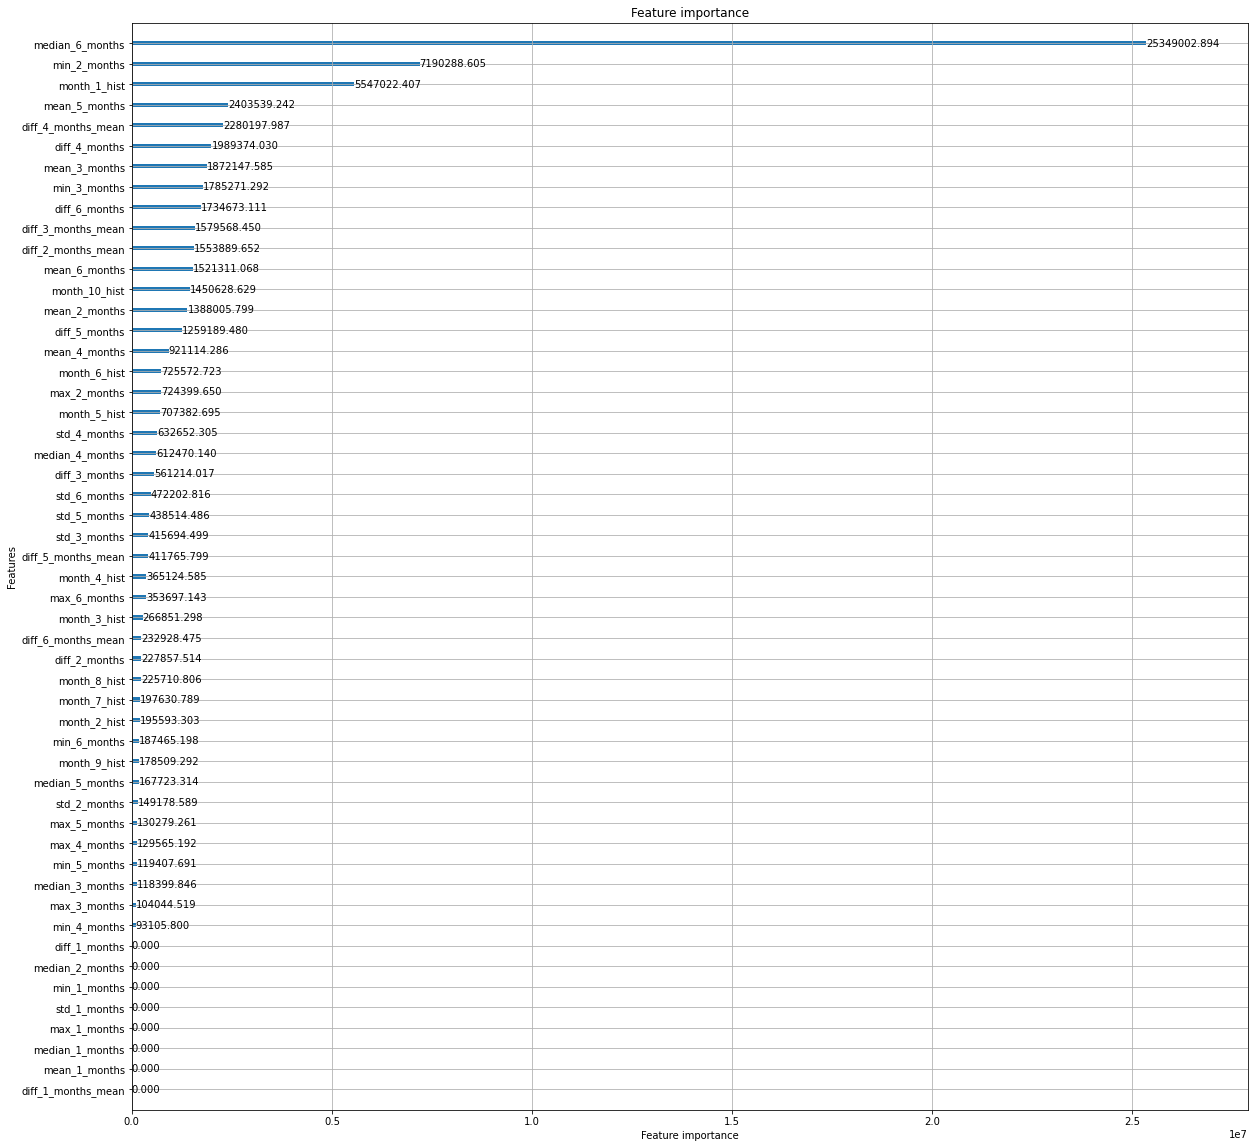

In [52]:
lgb.plot_importance(bst, ignore_zero=False,figsize=(20,20), importance_type='gain')

In [31]:
bst.feature_importance() >= 400

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False, False, False, False, False,  True,  True,
       False, False,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True])

In [35]:
saved_feature = np.array(bst.feature_name())[bst.feature_importance() >= 400]

In [37]:
X_train = X_train[saved_feature]
X_val = X_val[saved_feature]
X_test = test_X[saved_feature]

train_data = lgb.Dataset(X_train, y_train)
val_data = lgb.Dataset(X_val, y_val)
test_data = lgb.Dataset(X_test)

In [50]:
# param tuning
import optuna
from sklearn.metrics import mean_squared_error
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        "n_estimators" : trial.suggest_categorical("n_estimators", [5000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 21),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100)
        "max_bin":trial.suggest_int("max_bin", 200, 300, step=10),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=10),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=10),
        "main_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
    }
    model = lgb.LGBMRegressor(objective='regression', **param_grid)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, "rmse")])
    
    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    return score

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
shop_id = df_[df_['date_block_num']==0].shop_id
item_id = df_[df_['date_block_num']==0].item_id
y_pred = pd.DataFrame({
    'shop_id': shop_id,
    'item_id':item_id,
    'item_cnt_month': test_pred[0]
})
test = pd.read_csv('test.csv')
sub = pd.merge(test, y_pred, on=['shop_id', 'item_id'], how='left')
sub['item_cnt_month'] = sub['item_cnt_month'].fillna(0)
sub = sub.drop(columns=['shop_id', 'item_id'])
sub.to_csv('benchmark_with_lgb.csv',index=False)